<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/7_PRETRAIN_METHOD/GPT2/GPT2_KorSTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 여러 도구들 install

In [1]:
pip install sentencepiece==0.1.85

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 16.1 MB/s 


In [2]:
pip install gluonnlp==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 252 kB 14.4 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.9.1-cp37-cp37m-linux_x86_64.whl size=472284 sha256=491d9f431bba001fd5a01f74da6aaccb4da87118f533eec92a0b9874a42baf7c
  Stored in directory: /root/.cache/pip/wheels/d7/dd/b2/c023f6c9c83fb46b10f62f77ea526c4dad6913b967941bbe99
Successfully built gluonnlp


In [3]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 14.7 MB/s 
     |████████████████████████████████| 3.0 MB 53.7 MB/s 
     |████████████████████████████████| 880 kB 55.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e01e29056859ca2d80984536c0c8a51d654fc21c3e7dbe67a4b1f87c78a4e206
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


# 시작

In [5]:
import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [7]:
cd drive/MyDrive/GPT

/content/drive/MyDrive/GPT


In [8]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, alpha=0)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [11]:

BATCH_SIZE = 10
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
SENT_MAX_LEN = 14

DATA_IN_PATH = 'data_in'
DATA_OUT_PATH = "data_out"

In [12]:
# Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter = '\t', quoting = 3)

train_data = train_data.dropna()

dev_data = dev_data.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 5749, dev - 1500


In [13]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents1 = []
train_data_sents2 = []
train_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    train_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    train_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    train_data_sents1.append(tokens1)
    train_data_sents2.append(tokens2)
    train_labels.append(score)

train_data_sents1 = np.array(train_data_sents1, dtype=np.int64)
train_data_sents2 = np.array(train_data_sents2, dtype=np.int64)
train_data_sents = (train_data_sents1, train_data_sents2)
train_data_labels = np.array(train_labels)

In [14]:
dev_data_sents1 = []
dev_data_sents2 = []
dev_labels = []


for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    dev_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    dev_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    dev_data_sents1.append(tokens1)
    dev_data_sents2.append(tokens2)
    dev_labels.append(score)

dev_data_sents1 = np.array(dev_data_sents1, dtype=np.int64)
dev_data_sents2 = np.array(dev_data_sents2, dtype=np.int64)
dev_data_sents = (dev_data_sents1, dev_data_sents2)
dev_data_labels = np.array(dev_labels)

In [16]:
print("Shape of dataset: train - ({}, {}), dev - ({}, {})".format(train_data_sents[0].shape, train_data_sents[1].shape, dev_data_sents[0].shape, dev_data_sents[1].shape))

Shape of dataset: train - ((5749, 31), (5749, 31)), dev - ((1500, 31), (1500, 31))


In [17]:
class TFGPT2Regressor(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Regressor, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.regressor = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="regressior")
        
    def call(self, inputs):
        outputs1 = self.gpt2(inputs[0])
        outputs2 = self.gpt2(inputs[1])
        outputs = outputs1[0] + outputs2[0]
        pooled_output = outputs[:, -1, :]

        pooled_output = self.dropout(pooled_output)
        logits = self.regressor(pooled_output)

        return logits

In [18]:
regression_model = TFGPT2Regressor('./gpt_ckpt', 1)


If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [19]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)
        
        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []
        

    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        r_num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return r_num / r_den

In [20]:
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [21]:
model_name = "tf2_gpt_korsts"

earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=3,mode='max')

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

history = regression_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/tf2_gpt_korsts -- Folder create complete 

Epoch 1/3
575/575 [==============================] - ETA: 0s - loss: 2.2555 - pearson_correlation: 0.1244

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2086: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_pearson_correlation improved from -inf to 0.24147, saving model to data_out/tf2_gpt_korsts/weights.h5
575/575 [==============================] - 433s 752ms/step - loss: 2.2555 - pearson_correlation: 0.1244 - val_loss: 2.3657 - val_pearson_correlation: 0.2415
Epoch 2/3
575/575 [==============================] - ETA: 0s - loss: 1.1328 - pearson_correlation: 0.6869
Epoch 2: val_pearson_correlation improved from 0.24147 to 0.75137, saving model to data_out/tf2_gpt_korsts/weights.h5
575/575 [==============================] - 417s 726ms/step - loss: 1.1328 - pearson_correlation: 0.6869 - val_loss: 1.1433 - val_pearson_correlation: 0.7514
Epoch 3/3
575/575 [==============================] - ETA: 0s - loss: 0.6562 - pearson_correlation: 0.8331
Epoch 3: val_pearson_correlation improved from 0.75137 to 0.78774, saving model to data_out/tf2_gpt_korsts/weights.h5
575/575 [==============================] - 414s 720ms/step - loss: 0.6562 - pearson_correlation: 0.8331 - val_loss: 0.8612

In [23]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

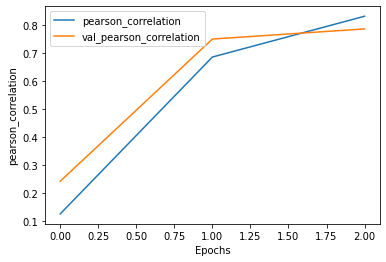

In [24]:
plot_graphs(history, 'pearson_correlation')

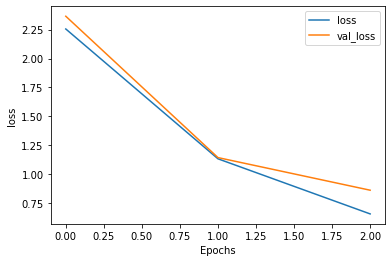

In [25]:
plot_graphs(history, 'loss')

# TEST

In [26]:
# Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-test.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.


In [27]:
test_data_sents1 = []
test_data_sents2 = []
test_labels = []


for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    test_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]] 
    tokens1 += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.sep_token]]  
    tokens1 += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]] 
    tokens2 += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.sep_token]]  
    tokens2 += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens2 += [vocab[vocab.eos_token]]
    
    test_data_sents1.append(tokens1)
    test_data_sents2.append(tokens2)
    test_labels.append(score)

test_data_sents1 = np.array(test_data_sents1, dtype=np.int64)
test_data_sents2 = np.array(test_data_sents2, dtype=np.int64)
test_data_sents = (test_data_sents1, test_data_sents2)
test_data_labels = np.array(test_labels)

In [28]:
print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 2, # labels: 1379


In [29]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_data_sents, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2086: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


3/3 [==============================] - 5s 2s/step - loss: 1.0752 - pearson_correlation: 0.7508
test loss, test pearson correlation:  [1.0751556158065796, 0.750823974609375]
